# Relátorio EP2: Cálculo do Conjunto de Mandelbrot com OpenMPI 

####Augusto Camargo nUSP: 11891023
####Henrique Gonçalves Salvador nUSP: 12415353
####Ísis Ardisson Logullo nUSP: 7577410
####Wesley Seidel Carvalho nUSP: 6544342

## 1. Introdução
O Exercício-Programa 2 (EP2) foi separado em três implementações diferentes, sendo duas utilizando processos e threads (MPI+OMP e MPI+Pthreads) e uma utilizando apenas processos (MPI) para a construção das imagens do Conjunto de Mandelbrot. Também foram utilizados os 3 programas do EP1 para comparação. Todos os experimentos foram executados na mesma máquina para manter a consistência dos dados comparativos das três versões. Para realização dos testes utilizamos um desktop com a seguinte configuração:

- CPU Intel(R) Core(TM) i7-10750H @ 2.60GHz
- Base speed 2,59GHz
- 16Gb de RAM
- Sockets:  1
- Cores:  6
- Logical processors:  12
- Virtualization:  Enabled 
- L1 cache:  384 KB 
- L2 cache:  1,5 MB
- L3 cache:  12,0 MB
- Ubuntu 20.04.2 LTS
- gcc version 9.3.0 (Ubuntu 9.3.0-17ubuntu1~20.04)
- Open MPI: 4.0.3
- Lenovo G5

Todos os experimentos usaram os parâmetros fixos: Repetições = 15, Tamanho
da Imagem = 4096, Região: Triple Spiral Valley.

Fizemos vários experimentos preliminares com:
* Processos: 1, 8, 16, 32 e 64 e um ensaio com 2 e 4. 
* Threads: 1, 2, 4, 8, 16 e 32. 

Dois resultados são importantes foram:

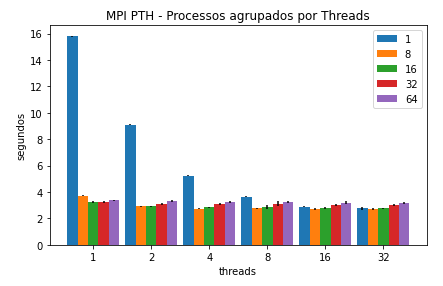

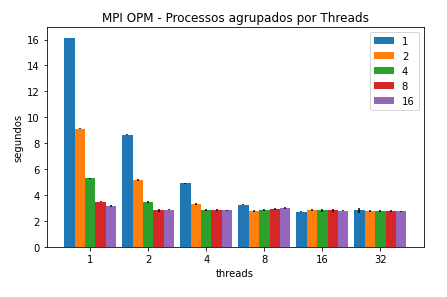

Baseando-se nesses experimentos criamos a conceito de workers, que é o numero de processos multiplicado pelo número de threads. Pelo resultados, detectamos que workers de valores semelhantes tem performance semelhante.

Analisamos os dados acima chegamos a hipótese que no presente hardware o número ótimo de workers estaria em torno de 12 que é número de processadores lógicos da máquina.

Assim repropusemos os valores dos experimentos para:
*   Processos: 1, 2, 3, 4, 6, 12, 16 
*   Threads: 1, 2, 3, 4, 6, 12, 16 

Os valores acima foram escolhidos para testar a hipótese se 12 workers realmente era o valor mais eficiente. (Este procedimento foi sugerido/validado com a monitora Elisa).


## 2. Resultados
### 2.1 Dados coletados



In [34]:
import pandas as pd
import io
import requests
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline  

Em seguida foram calculados, sobre os dados dos experimentos, a média e o intervalo de confiança. Para o cálculo foram consideradas as 15 medições/execuções realizadas para cada experimento. Para o cálculo do intervalo de confiança de 95% utilizou-se a seguinte fórmula: 
$$\Big( \bar{x} - 1,96 \times \frac{\sigma}{\sqrt{n}},\quad \bar{x} + 1,96 \times \frac{\sigma}{\sqrt{n}}\Big)$$

In [35]:
#
# Média
# Intervalo de confiança
#
def mean_confidence_interval_m(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m #, m-h, m+h
def mean_confidence_interval_h(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return h  

In [36]:
def grafico_MPI(source,titulo,ilabel):
  
  if(ilabel == 0):
    labels = ['1']
  else:
    labels = ['1','2','3','4','6','12','16']

  ep2_log_1 = source[(source.Processos == 1)]
  ep2_log_1_e = np.array(ep2_log_1.Total_Intevalo_Confianca)
  ep2_log_1_m = np.array(ep2_log_1.Total_media)

  ep2_log_2 = source[(source.Processos == 2)]
  ep2_log_2_e = np.array(ep2_log_2.Total_Intevalo_Confianca)
  ep2_log_2_m = np.array(ep2_log_2.Total_media)

  ep2_log_3 = source[(source.Processos == 3)]
  ep2_log_3_e = np.array(ep2_log_3.Total_Intevalo_Confianca)
  ep2_log_3_m = np.array(ep2_log_3.Total_media)

  ep2_log_4 = source[(source.Processos == 4)]
  ep2_log_4_e = np.array(ep2_log_4.Total_Intevalo_Confianca)
  ep2_log_4_m = np.array(ep2_log_4.Total_media)

  ep2_log_6 = source[(source.Processos == 6)]
  ep2_log_6_e = np.array(ep2_log_6.Total_Intevalo_Confianca)
  ep2_log_6_m = np.array(ep2_log_6.Total_media)

  ep2_log_12 = source[(source.Processos == 12)]
  ep2_log_12_e = np.array(ep2_log_12.Total_Intevalo_Confianca)
  ep2_log_12_m = np.array(ep2_log_12.Total_media)

  ep2_log_16 = source[(source.Processos == 16)]
  ep2_log_16_e = np.array(ep2_log_16.Total_Intevalo_Confianca)
  ep2_log_16_m = np.array(ep2_log_16.Total_media)

  x = np.arange(len(labels))  
  width = 1

  fig, ax = plt.subplots()
  rects1 = ax.bar(x -  width*(3/8)  , ep2_log_1_m,width/7,  yerr=ep2_log_1_e,  label='1')
  rects2 = ax.bar(x -  width*(2/8) , ep2_log_2_m,width/7,  yerr=ep2_log_2_e,  label='2')
  rects3 = ax.bar(x -  width*(1/8) , ep2_log_3_m,width/7,  yerr=ep2_log_3_e,  label='3')
  rects4 = ax.bar( x            , ep2_log_4_m,width/7,  yerr=ep2_log_4_e,  label='4')
  rects6 = ax.bar(x  + width*(1/8) , ep2_log_6_m,width/7,  yerr=ep2_log_6_e,  label='6')
  rects12 = ax.bar(x + width*(2/8) , ep2_log_12_m,width/7, yerr=ep2_log_12_e, label='12')
  rects16 = ax.bar(x + width*(3/8)  , ep2_log_16_m,width/7, yerr=ep2_log_16_e, label='16')
  
  ax.set_ylabel('segundos')
  ax.set_xlabel('threads')
  ax.set_title(titulo)
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()
  
  fig.tight_layout()
  plt.rcParams["figure.figsize"] = (8, 6)
  plt.show()

###2.2 Otimizações
Dependendo da forma que é feito a paralelização pode-se gerar um agravante no uso de memória. Por conta disso, na nossa implementação optamos por otimizar esse ponto. Usamos vetores para armazenar o buffer que gera a imagem de mandelbrot, mas passamos pelos processos do MPI, apenas uma fração dessa imagem, com um vetor delimitante. Assim os processos se comunicavam, mandando apenas "faixas" restritas da imagem e alocando somente as quantidades necessárias para essa faixas no dado processo, e não ela completa. No final essas faixas são unidas, formando a imagem inteira. Assim conseguimos contornar o uso excessivo de memória. Os trechos dos códigos citados segue abaixo, ilustrando bem a solução:



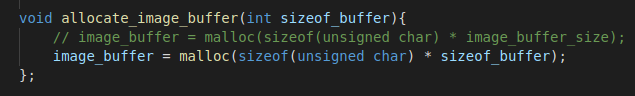

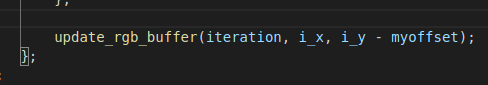

## 3. Discussões
### 3.1 Sequencial

Como observamos no EP1, a implementação sequencial apenas tem vantagem aos outros métodos quando usamos apenas 1 thread ou processo. Acaba sendo um pouco mais rápido, mas essa vantagem diminui com o intervalo de confiança. Essa versão tem mais o intuito de comparação da vantagem do uso de threads e processos, sendo uma base de tempo.

In [37]:
# 
# Sequencial
#
url="https://lab.fuzzy.com.br/pages/assets/scratch/MAC0219EP2/ep2_log_seq.csv"
s=requests.get(url).content
ep2_log_seq=pd.read_csv(io.StringIO(s.decode('utf-8')),sep=";")
ep2_log_seq.columns =['Exe','Tipo','Regiao','Tamanho','Threads','Repeticoes','Init','Allocate','Madelbrot','Write','Total','null']
ep2_log_seq = ep2_log_seq.groupby(['Tipo', 'Threads']).agg({'Total': [ mean_confidence_interval_m,mean_confidence_interval_h]})
ep2_log_seq.columns = ['Total_media','Total_Intevalo_Confianca']
ep2_log_seq = ep2_log_seq.reset_index()
print(ep2_log_seq)

  Tipo  Threads  Total_media  Total_Intevalo_Confianca
0  SEQ        1     15.68047                  0.094355


###3.2 Pthread

Inserindo paralelização no programa, observou-se uma melhora considerável, comparativamente ao tempo sequencial. Ao paralelizar o código, o trabalho é dividido pelo diversos núcleos do processador e com isso, adotando as configurações necessárias, observa-se um ganho significativo em velocidade. Pthreads teve uma pequena vantagem sobre o OpenMP nos experimentos. Como podemos ver, inicialmente OpenMP tem uma ligeira vantagem com 1 thread, mas com o aumento do número de threads isso se perde e o Pthread passa a frente por alguns segundos. Mas essa diferença é quase nula se levarmos em conta o intervalo de confiança.

In [38]:
#
# PTH
#
url="https://lab.fuzzy.com.br/pages/assets/scratch/MAC0219EP2/ep2_log_t_pth.csv"
s=requests.get(url).content
ep2_log_t_pth=pd.read_csv(io.StringIO(s.decode('utf-8')),sep=";")
ep2_log_t_pth.columns =['Exe','Tipo','Regiao','Tamanho','Threads','Repeticoes','Init','Allocate','Madelbrot','Write','Total','null']
ep2_log_t_pth = ep2_log_t_pth.groupby(['Tipo', 'Threads']).agg({'Total': [ mean_confidence_interval_m,mean_confidence_interval_h]})
ep2_log_t_pth.columns = ['Total_media','Total_Intevalo_Confianca']
ep2_log_t_pth = ep2_log_t_pth.reset_index()
print(ep2_log_t_pth)

  Tipo  Threads  Total_media  Total_Intevalo_Confianca
0  PTH        1    15.500823                  0.034013
1  PTH        2     8.443605                  0.031469
2  PTH        3     6.109413                  0.042055
3  PTH        4     4.991790                  0.146463
4  PTH        6     3.823958                  0.110899
5  PTH       12     2.678777                  0.063102
6  PTH       16     2.766303                  0.112714


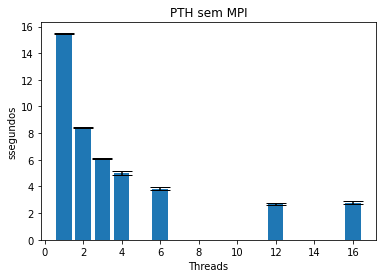

In [39]:
plt.bar(ep2_log_t_pth.Threads,ep2_log_t_pth.Total_media  ,yerr=ep2_log_t_pth.Total_Intevalo_Confianca, capsize=10)
plt.xlabel('Threads')
plt.ylabel('ssegundos')
plt.title('PTH sem MPI')
plt.show()

###3.3 OpenMP

As threads tem sua perda de escabilidade em entre 6, 8 e 16, no estudo apresentado. Muito provavelmente associativo com o número (12) de processadores lógicos do computador usado. O uso do intervalo de confiança, confirma ainda mais toda a análise aproximando os resultados, evitando também possíveis inconsistências de ruídos pontuais.
O melhor ajuste foi dividir o cálculo de Mandelbrot utilizando a configuração do Schedule do pragma como 'dynamic' e 'chunk' 16. Ao analisar o número de threads mais adequados para computar o Mandelbrot para o nosso equipamento, observou-se que houve ganho significativo ao adicionar threads até o número de 12 threads. Acima disso, os ganhos foram atenuados e permaneceram quase estáveis ao analisar 16 e 32 threads (vide introdulção).

In [40]:
#
# OMP
#
url="https://lab.fuzzy.com.br/pages/assets/scratch/MAC0219EP2/ep2_log_t_omp.csv"
s=requests.get(url).content
ep2_log_t_omp=pd.read_csv(io.StringIO(s.decode('utf-8')),sep=";")
ep2_log_t_omp.columns =['Exe','Tipo','Regiao','Tamanho','Threads','Repeticoes','Init','Allocate','Madelbrot','Write','Total','null']
ep2_log_t_omp_g = ep2_log_t_omp.groupby(['Tipo', 'Threads']).agg({'Total': [ mean_confidence_interval_m,mean_confidence_interval_h]})
ep2_log_t_omp_g.columns = ['Total_media','Total_Intevalo_Confianca']
ep2_log_t_omp_g = ep2_log_t_omp_g.reset_index()
print(ep2_log_t_omp_g)

  Tipo  Threads  Total_media  Total_Intevalo_Confianca
0  OMP        1    15.626462                  0.065796
1  OMP        2     8.504340                  0.104002
2  OMP        3     6.107965                  0.026473
3  OMP        4     4.983932                  0.064354
4  OMP        6     3.815655                  0.062172
5  OMP       12     2.778089                  0.117270
6  OMP       16     2.754033                  0.093303


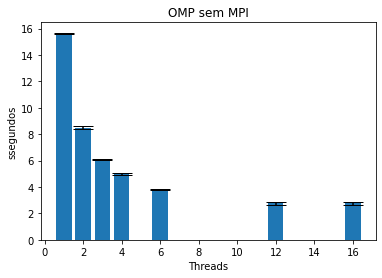

In [41]:
plt.bar(ep2_log_t_omp_g.Threads,ep2_log_t_omp_g.Total_media  ,yerr=ep2_log_t_omp_g.Total_Intevalo_Confianca, capsize=10)
plt.xlabel('Threads')
plt.ylabel('ssegundos')
plt.title('OMP sem MPI')
plt.show()

###3.4 MPI Sequencial

Começamos a analisar o comportamento dos processos do MPI. Com apenas um processo ele já apresenta uma pequena vantagem ao sequencial puro. Porém, essa vantagem se perde rapidamente com o aumento dos processos. Comparativamente às versões de threads puras (Pthread e OpenMP). Ele apresenta uma demora maior considerável, pensando nessa dualidade pura thread x processo. Isso se deve ao uso maior de memória para a comunicação e transmissão das mensagens entre o send e o receive. E assim como as threads, se estabiliza a partir de 12 processos.

In [42]:
# 
# MPI Sequencial
#
url="https://lab.fuzzy.com.br/pages/assets/scratch/MAC0219EP2/ep2_log_m_seq.csv"
s=requests.get(url).content
ep2_log_m_seq=pd.read_csv(io.StringIO(s.decode('utf-8')),sep=";")
ep2_log_m_seq.columns =['Exe','Tipo','Regiao','Tamanho','Processos','Threads','Repeticoes','Init','Allocate','Madelbrot','Write','Total','null']
ep2_log_m_seq = ep2_log_m_seq.groupby(['Tipo', 'Processos','Threads']).agg({'Total': [ mean_confidence_interval_m,mean_confidence_interval_h]})
ep2_log_m_seq.columns = ['Total_media','Total_Intevalo_Confianca']
ep2_log_m_seq = ep2_log_m_seq.reset_index()
print(ep2_log_m_seq)

    Tipo  Processos  Threads  Total_media  Total_Intevalo_Confianca
0  m_SEQ          1        1    15.714541                  0.007819
1  m_SEQ          2        1     9.001874                  0.014421
2  m_SEQ          3        1     6.616173                  0.041419
3  m_SEQ          4        1     5.237343                  0.031111
4  m_SEQ          6        1     4.003092                  0.038322
5  m_SEQ         12        1     2.732555                  0.048973
6  m_SEQ         16        1     3.272047                  0.137393


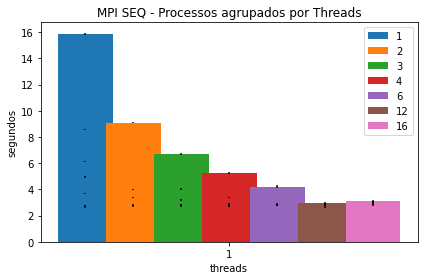

In [43]:
grafico_MPI(ep2_log_m_omp,'MPI SEQ - Processos agrupados por Threads',0)

###3.5 MPI OpenMP

A partir do uso misto de threads e processos, começamos a ver o real potencial de otimização dessas duas tecnologias. Nota-se um comportamento parecido invertido na relação entre threads e processos. Por exemplo, 3 processos com 4 threads é razoavelmente semelhante a 4 processos com 3 threads. Aqui também o 12 é o número ideal de workers.

In [44]:
# 
# MPI OMP
#
url="https://lab.fuzzy.com.br/pages/assets/scratch/MAC0219EP2/ep2_log_m_omp.csv"
s=requests.get(url).content
ep2_log_m_omp=pd.read_csv(io.StringIO(s.decode('utf-8')),sep=";")
ep2_log_m_omp.columns =['Exe','Tipo','Regiao','Tamanho','Processos','Threads','Repeticoes','Init','Allocate','Madelbrot','Write','Total','null']
ep2_log_m_omp = ep2_log_m_omp.groupby(['Tipo', 'Processos','Threads']).agg({'Total': [ mean_confidence_interval_m,mean_confidence_interval_h]})
ep2_log_m_omp.columns = ['Total_media','Total_Intevalo_Confianca']
ep2_log_m_omp = ep2_log_m_omp.reset_index()
print(ep2_log_m_omp)

     Tipo  Processos  Threads  Total_media  Total_Intevalo_Confianca
0   m_OMP          1        1    15.879060                  0.079991
1   m_OMP          1        2     8.588481                  0.040318
2   m_OMP          1        3     6.158590                  0.033656
3   m_OMP          1        4     4.920163                  0.072834
4   m_OMP          1        6     3.709041                  0.037713
5   m_OMP          1       12     2.718313                  0.101227
6   m_OMP          1       16     2.751977                  0.045250
7   m_OMP          2        1     9.107739                  0.020432
8   m_OMP          2        2     5.158639                  0.017336
9   m_OMP          2        3     3.979504                  0.041588
10  m_OMP          2        4     3.383506                  0.060936
11  m_OMP          2        6     2.722108                  0.046963
12  m_OMP          2       12     2.788657                  0.070533
13  m_OMP          2       16     

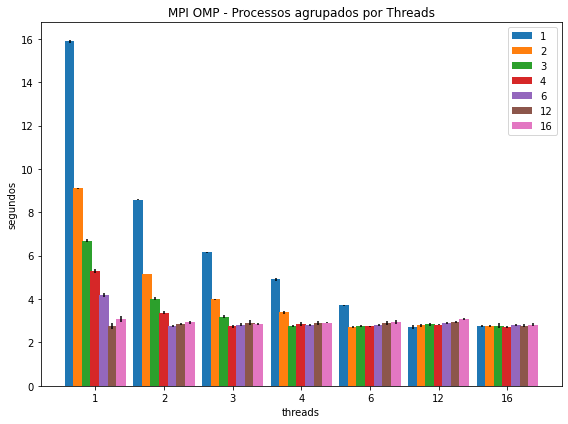

In [45]:
grafico_MPI(ep2_log_m_omp,'MPI OMP - Processos agrupados por Threads',1)

###3.6 MPI Pthread

A pequena vantagem que o Pthread puro leva sobre o OpenMP também á visível aqui. O comportamento é bem parecido com o MPI + OpenMP. Porém tem uma vantagem de alguns segundos a menos, conforme vimos na comparação pura Pthreads x OpenMP. Mas com o intervalo de confiança isso quase some, deixando ambas implementações mistas bem semelhantes.

In [46]:
# 
# MPI pth
#
url="https://lab.fuzzy.com.br/pages/assets/scratch/MAC0219EP2/ep2_log_m_pth.csv"
s=requests.get(url).content
ep2_log_m_pth=pd.read_csv(io.StringIO(s.decode('utf-8')),sep=";")
ep2_log_m_pth.columns =['Exe','Tipo','Regiao','Tamanho','Processos','Threads','Repeticoes','Init','Allocate','Madelbrot','Write','Total','null']
ep2_log_m_pth = ep2_log_m_pth.groupby(['Tipo', 'Processos','Threads']).agg({'Total': [ mean_confidence_interval_m,mean_confidence_interval_h]})
ep2_log_m_pth.columns = ['Total_media','Total_Intevalo_Confianca']
ep2_log_m_pth = ep2_log_m_pth.reset_index()
print(ep2_log_m_pth)

     Tipo  Processos  Threads  Total_media  Total_Intevalo_Confianca
0   m_PTH          1        1    15.772501                  0.023083
1   m_PTH          1        2     9.034607                  0.011437
2   m_PTH          1        3     6.698373                  0.021572
3   m_PTH          1        4     5.223137                  0.044230
4   m_PTH          1        6     4.045401                  0.071005
5   m_PTH          1       12     2.759623                  0.040953
6   m_PTH          1       16     2.911999                  0.092314
7   m_PTH          2        1     9.054529                  0.043327
8   m_PTH          2        2     5.248935                  0.014420
9   m_PTH          2        3     4.009622                  0.090915
10  m_PTH          2        4     3.541073                  0.040068
11  m_PTH          2        6     2.782289                  0.041820
12  m_PTH          2       12     2.754256                  0.044987
13  m_PTH          2       16     

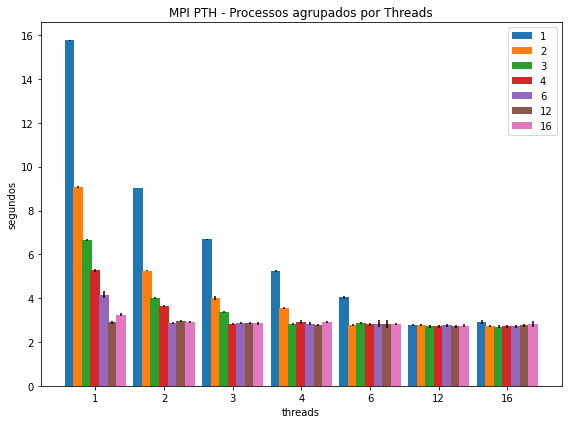

In [47]:
grafico_MPI(ep2_log_m_pth,'MPI PTH - Processos agrupados por Threads',1)

In [48]:
def grafico_MPI_2_4(source,titulo,ilabel):
  

  if(ilabel == 0):
    labels = ['1']
  else:
    labels = ['1', '2', '4', '8', '16', '32']

  ep2_log_1 = ep2_log_m_omp[(source.Processos == 1)]
  ep2_log_1_e = np.array(ep2_log_1.Total_Intevalo_Confianca)
  ep2_log_1_m = np.array(ep2_log_1.Total_media)

  ep2_log_2 = ep2_log_m_omp[(source.Processos == 2)]
  ep2_log_2_e = np.array(ep2_log_2.Total_Intevalo_Confianca)
  ep2_log_2_m = np.array(ep2_log_2.Total_media)

  ep2_log_4 = ep2_log_m_omp[(source.Processos == 4)]
  ep2_log_4_e = np.array(ep2_log_4.Total_Intevalo_Confianca)
  ep2_log_4_m = np.array(ep2_log_4.Total_media)

  ep2_log_8 = ep2_log_m_omp[(source.Processos == 8)]
  ep2_log_8_e = np.array(ep2_log_8.Total_Intevalo_Confianca)
  ep2_log_8_m = np.array(ep2_log_8.Total_media)

  ep2_log_16 = ep2_log_m_omp[(source.Processos == 16)]
  ep2_log_16_e = np.array(ep2_log_16.Total_Intevalo_Confianca)
  ep2_log_16_m = np.array(ep2_log_16.Total_media)


  x = np.arange(len(labels))  # the label locations
  width = 1.8  # the width of the bars

  fig, ax = plt.subplots()
  rects1 = ax.bar(x - width/5 , ep2_log_1_m,width/10, yerr=ep2_log_1_e, label='1')
  rects8 = ax.bar(x - width/10 , ep2_log_2_m,width/10, yerr=ep2_log_2_e, label='2')
  rects16 = ax.bar(x , ep2_log_4_m,width/10, yerr=ep2_log_4_e, label='4')
  rects32 = ax.bar(x + width/10 , ep2_log_8_m,width/10, yerr=ep2_log_8_e, label='8')
  rects64 = ax.bar(x + width/5 , ep2_log_16_m,width/10, yerr=ep2_log_16_e, label='16')

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('segundos')
  ax.set_xlabel('threads')
  ax.set_title(titulo)
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

  fig.tight_layout()

  plt.show()

In [49]:
# 
# MPI OMP
#
url="https://lab.fuzzy.com.br/pages/assets/scratch/MAC0219EP2/ep2_log_m_omp.csv"
s=requests.get(url).content
ep2_log_m_omp=pd.read_csv(io.StringIO(s.decode('utf-8')),sep=";")
ep2_log_m_omp.columns =['Exe','Tipo','Regiao','Tamanho','Processos','Threads','Repeticoes','Init','Allocate','Madelbrot','Write','Total','null']
ep2_log_m_omp = ep2_log_m_omp.groupby(['Tipo', 'Processos','Threads']).agg({'Total': [ mean_confidence_interval_m,mean_confidence_interval_h]})
ep2_log_m_omp.columns = ['Total_media','Total_Intevalo_Confianca']
ep2_log_m_omp = ep2_log_m_omp.reset_index()
print(ep2_log_m_omp)

     Tipo  Processos  Threads  Total_media  Total_Intevalo_Confianca
0   m_OMP          1        1    15.879060                  0.079991
1   m_OMP          1        2     8.588481                  0.040318
2   m_OMP          1        3     6.158590                  0.033656
3   m_OMP          1        4     4.920163                  0.072834
4   m_OMP          1        6     3.709041                  0.037713
5   m_OMP          1       12     2.718313                  0.101227
6   m_OMP          1       16     2.751977                  0.045250
7   m_OMP          2        1     9.107739                  0.020432
8   m_OMP          2        2     5.158639                  0.017336
9   m_OMP          2        3     3.979504                  0.041588
10  m_OMP          2        4     3.383506                  0.060936
11  m_OMP          2        6     2.722108                  0.046963
12  m_OMP          2       12     2.788657                  0.070533
13  m_OMP          2       16     

##4. Conclusões

As figuras de Madelbrot se mostraram um objeto interessante para testar recursos de paralelismo, elas conseguiram expor as sutilezas do comportamento do hardware, da linguagem de programação, das API de paralelismo e ainda do Sistema Operacional.
Otimizar o paralelismo é um desafio matricial: tem-se que levar em conta o conjunto quadrático formado pelas variáveis do problema.
Os resultados obtidos mostram que o uso pleno de um hardware atual requer o estudo e a aplicação de recursos de paralelismo, inclusive o misto, isso quando o objeto em questão o permitir, pois caso contrário uma quantidade grande de recursos computacionais que impactam na experiência do usário estarão sendo subutilizados.
A tecnologia utilizada de paralelismo misto (threads + processos) mostrou-se com ótimo custo benefício: com pouco esforço de programação pudemos diminuir em até 8x o tempo para solução do problema. Melhor do que apenas a forma pura de paralelismo que tinha diminuição de 5x o tempo. Também é preciso notar que ela deve ser usada com parcimônia, pois em alguns casos o grande número de processos mistos acaba piorando o resultado do programa. Esse experimento comprovou que o melhor número de workers (12) se relaciona com o número de cores lógicos da máquina utilizada.